# Markov Chain ELG Redshift Fitting

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.table
import astropy.constants
import astropy.units as u

CLIGHT_KM_S = astropy.constants.c.to(u.km / u.s).value

In [3]:
import time

## ELG Model

Generate a rest-frame doublet spectrum using the specified parameter values:

In [4]:
def oii_doublet(wlen, total_flux=8., peak1_wlen=3727.092, peak2_wlen=3729.874, flux_ratio12=0.73, sigma_v=75.):
    """
    total_flux : float
        Total rest-frame flux in units of 1e-17 erg / (cm2 s A)
    peak1_wlen : float
        Rest wavelength of the left-most peak in Angstroms.
    peak2_wlen : float
        Rest wavelength of the right-most peak in Angstroms.
    flux_ratio12 : float
        Ratio of flux in peak1 to peak2.  Dimensionless.
    sigma_v : float
        Rest-frame velocity dispersion of the peaks in km/s.
    """
    sigma_log_wlen = sigma_v / CLIGHT_KM_S
    log_wlen = np.log(wlen)
    flux1 = total_flux * flux_ratio12 / (1 + flux_ratio12)
    flux2 = total_flux / (1 + flux_ratio12)
    denom = np.sqrt(2 * np.pi) * sigma_log_wlen
    amp1 = flux1 / peak1_wlen / denom
    amp2 = flux2 / peak2_wlen / denom
    flux = (
        amp1 * np.exp(-0.5 * ((log_wlen - np.log(peak1_wlen)) / sigma_log_wlen)**2) +
        amp2 * np.exp(-0.5 * ((log_wlen - np.log(peak2_wlen)) / sigma_log_wlen)**2))
    return flux

Initialize the wavelength grid for doublets with z ~ 1.0:

In [5]:
def init_wlen(z_center, num_pixels=30, pixel_size=1., oversampling=20):

    wlen_center = 3728.5 * (1 + z_center)
    wlen_lo = wlen_center - 0.5 * num_pixels * pixel_size
    wlen_hi = wlen_center + 0.5 * num_pixels * pixel_size
    pixel_edges = np.linspace(wlen_lo, wlen_hi, num_pixels + 1)
    pixel_centers = 0.5 * (pixel_edges[1:] + pixel_edges[:-1])
    os_edges = np.linspace(wlen_lo, wlen_hi, oversampling * num_pixels + 1)
    os_centers = 0.5 * (os_edges[1:] + os_edges[:-1])
    return pixel_edges, pixel_centers, os_centers

In [6]:
z0 = 1.0
oversampling = 20

In [7]:
pixel_edges, pixel_centers, os_centers = init_wlen(z_center = z0, oversampling=oversampling)

Calculate velocity error of z relative to z0 in km/s:

In [8]:
def dvel(z):
    return CLIGHT_KM_S * (z - z0) / (1. + z0)

Invert this relationship:

In [9]:
def zval(dv):
    return z0 + dv / CLIGHT_KM_S * (1 + z0)

Generate an observed-frame doublet spectrum downsampled to observed pixels:

In [91]:
def doublet_model(dv, total_rest_flux=8., flux_ratio12=0.73, sigma_v=75., oversampling=20):
    z = zval(dv)
    # Convert oversampled observed bin edges to rest frame with this redshift.
    wlen_rest = os_centers / (1. + z)
    # Calculate observed ELG doublet mean flux on oversampled grid.
    os_flux = oii_doublet(wlen_rest, total_rest_flux, flux_ratio12=flux_ratio12, sigma_v=sigma_v) / (1. + z)
    # Downsample to observed pixels.
    pixel_flux = np.mean(os_flux.reshape(-1,oversampling), axis=-1)
    return pixel_flux

Generate a data set to analyze. Noise is specified by a total SNR for the peak and assumed to be constant per pixel.

In [92]:
def get_sigma(flux, snr):
    return np.sqrt(np.sum(flux ** 2)) / snr

In [93]:
def generate(dv, total_rest_flux=8., flux_ratio12=0.73, sigma_v=75., bg_flux = 0.5, snr=10., gen=None):
    M = doublet_model(dv, total_rest_flux, flux_ratio12, sigma_v)
    sigma_flux = get_sigma(M, snr)
    M += bg_flux
    if not isinstance(gen, np.random.RandomState):
        gen = np.random.RandomState(gen)
    return M + sigma_flux * gen.randn(len(M)), sigma_flux

In [94]:
def plot_generated(dv, total_rest_flux=8., flux_ratio12=0.73, sigma_v=75., bg_flux = 0.5,
                   snr=10., gen=None, chain=None):
    pixel_flux = doublet_model(dv, total_rest_flux, flux_ratio12, sigma_v) + bg_flux
    smooth = doublet_model(dv, total_rest_flux, flux_ratio12, sigma_v, oversampling=1) + bg_flux
    noisy, sigma_flux = generate(dv, total_rest_flux, flux_ratio12, sigma_v, bg_flux, snr, gen)
    #
    #plt.hist(x=pixel_centers, bins=pixel_edges, weights=pixel_flux, color='b', alpha=0.25, histtype='stepfilled')
    plt.hist(x=pixel_centers, bins=pixel_edges, weights=pixel_flux, color='b', histtype='step')
    plt.plot(os_centers, smooth, 'b-', lw=2)
    if chain is not None:
        for theta in chain:
            sample = doublet_model(*theta[:4], oversampling=1) + theta[4]
            plt.plot(os_centers, sample, 'r-', lw=1, alpha=0.2)
    plt.errorbar(x=pixel_centers, y=noisy, yerr=sigma_flux, ls='none', marker='o', color='k')
    plt.xlim(pixel_edges[0], pixel_edges[-1])
    plt.xlabel('Observed Wavelength [A]')
    plt.ylabel('Observed Flux [$\\times 10^{17}\,\mathrm{erg}/(\mathrm{cm}^2\mathrm{s}\,\mathrm{A})$]')

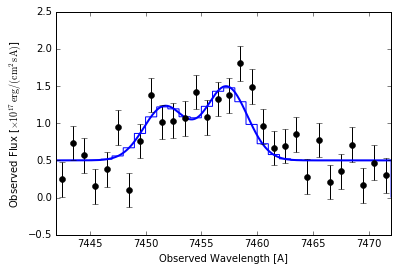

In [95]:
plot_generated(-100., snr=10., gen=123)

## EMCEE Analysis

Calculate the log-likelihood of a generated data set:

In [20]:
def loglike(dv, total_rest_flux, flux_ratio12, sigma_v, bg_flux, D, sigma_flux, dv_max=300.):
    M = doublet_model(dv, total_rest_flux, flux_ratio12, sigma_v) + bg_flux
    pulls = (D - M) / sigma_flux
    return -0.5 * np.dot(pulls, pulls)

Calculate the log-prior of the parameters.  We assume flat priors in dv and sigma_v, and Gaussian priors in flux and ratio12:

In [21]:
def logprior(dv, total_rest_flux, flux_ratio12, sigma_v, bg_flux):
    result = 0.
    
    # Uniform prior on -300 < dv < 300
    if np.abs(dv) >= 300:
        return -numpy.inf
    # Uniform prior on 25 < sigma_v < 300
    if sigma_v <= 25 or sigma_v >= 300:
        return -numpy.inf
    # Gaussian prior on total_rest_flux.
    mu, sigma = 10., 2.
    result -= 0.5 * ((total_rest_flux - mu) / sigma) ** 2
    # Gaussian prior on flux_ratio12.
    mu, sigma = 0.8, 0.2
    result -= 0.5 * ((flux_ratio12 - mu) / sigma) ** 2
    # Gaussian prior on bg_flux.
    mu, sigma = 0., 5.
    result -= 0.5 * ((bg_flux - mu) / sigma) ** 2
    
    return result

Combine the log-likelihood and log-prior into the log-posterior:

In [22]:
def logpost(theta, D, sigma_flux):
    dv, total_rest_flux, flux_ratio12, sigma_v, bg_flux = theta
    return (logprior(dv, total_rest_flux, flux_ratio12, sigma_v, bg_flux) +
            loglike(dv, total_rest_flux, flux_ratio12, sigma_v, bg_flux, D, sigma_flux))

Generate a random set of parameters sampled from the prior.

In [23]:
def get_random_params(n, gen):
    params = np.empty((n, 5))
    # Sample dv from uniform prior.
    params[:, 0] = gen.uniform(-300., +300., size=n)
    # Sample total_rest_flux from normal prior.
    params[:, 1] = gen.normal(10., 2., size=n)
    # Sample flux_ratio12 from normal prior.
    params[:, 2] = gen.normal(0.8, 0.2, size=n)
    # Sample sigma_v from uniform prior.
    params[:, 3] = gen.uniform(25., 300., size=n)
    # Sample bg_flux from normal prior.
    params[:, 4] = gen.normal(0., 5., size=n)
    return params

In [24]:
import emcee
import corner

In [25]:
def build_emcee_chain(dv_truth, flux_truth, ratio_truth, sigv_truth, bg_truth,
                snr=10., nkeep=20000, nburn=100, save=None, seed=1):
    # Generate the data to fit for this study.
    gen = np.random.RandomState(seed) if seed else None
    D, sigma_flux = generate(dv_truth, flux_truth, ratio_truth, sigv_truth, bg_truth, snr, gen=gen)
    # Initialize the sampler.
    ndim, nwalkers = 5, 20
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=[D, sigma_flux])
    # Generate random initial parameters for each walker.
    theta0 = get_random_params(nwalkers, gen)
    # Run the sampler.
    begin = time.time()
    sampler.run_mcmc(theta0, nburn + nkeep // nwalkers)
    elapsed = time.time() - begin
    print 'Sampling took {0:.1f} seconds.'.format(elapsed)
    samples = sampler.chain[:, nburn:].reshape(-1, ndim)
    # Display the results.
    fig = corner.corner(samples,
                        labels=["$\Delta v$ [km/s]", "Rest Flux", "Ratio12", "$\sigma_v$ [km/s]", "BG Flux"],
                        truths=[dv_truth, flux_truth, ratio_truth, sigv_truth, bg_truth],
                        quantiles=(0.16, 0.5, 0.84),
                        truth_color='r', color='b', show_titles=True)
    if save:
        fig.savefig(save)

    return samples

### Examples

Sampling took 1.8 seconds.


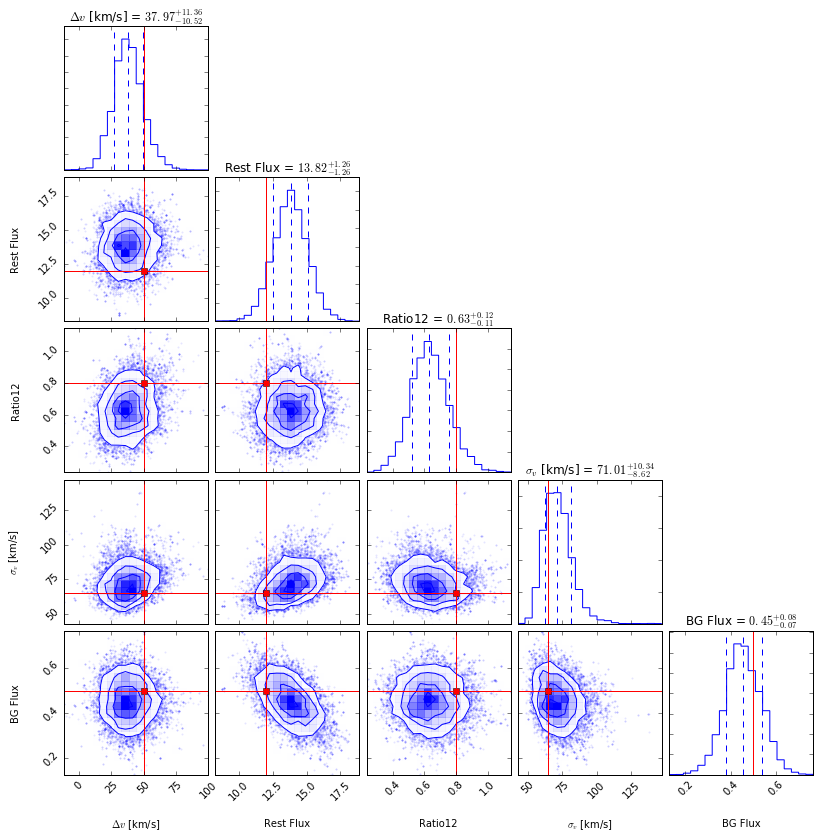

In [26]:
emcee_chain = build_emcee_chain(
    dv_truth=50., flux_truth=12., ratio_truth=0.8, sigv_truth=65., bg_truth=0.5, snr=10., seed=123)

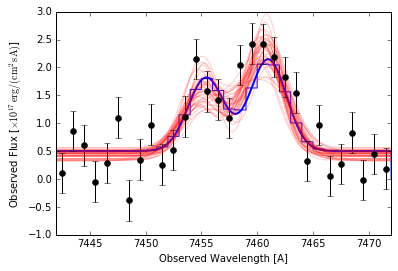

In [27]:
plot_generated(50., 12., 0.8, 65., 0.5, 10., 123, emcee_chain[::500])

Sampling took 2.1 seconds.


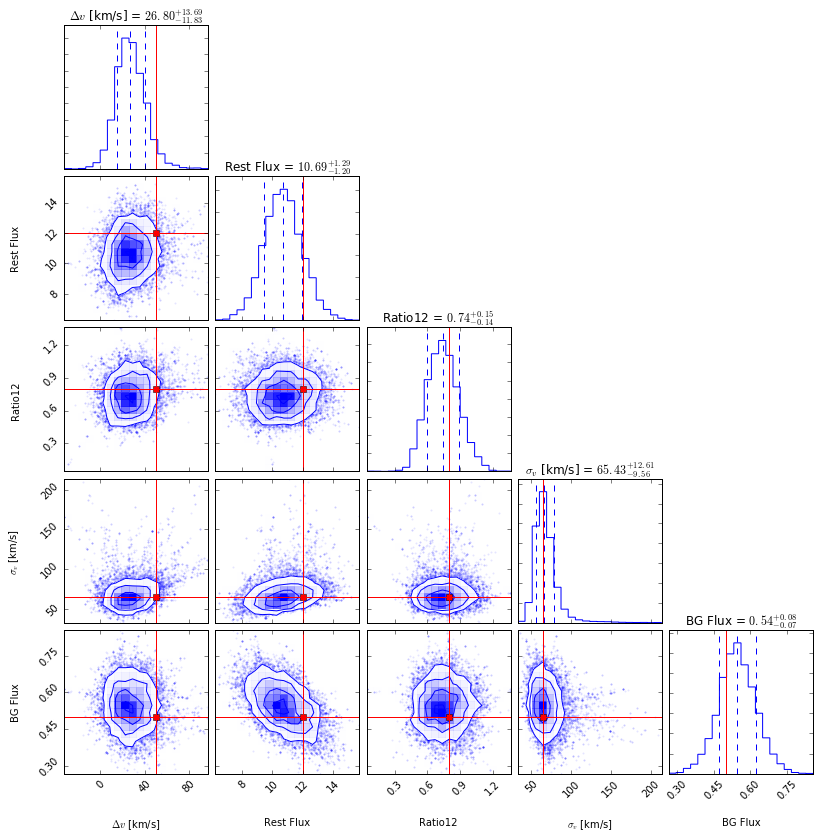

In [28]:
emcee_chain2 = build_emcee_chain(
    dv_truth=50., flux_truth=12., ratio_truth=0.8, sigv_truth=65., bg_truth=0.5, snr=10., seed=1234)

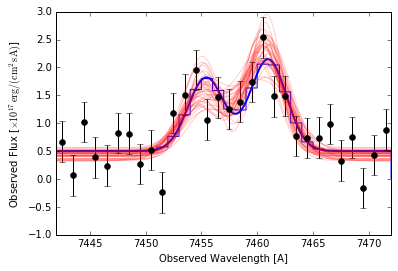

In [29]:
plot_generated(50., 12., 0.8, 65., 0.5, 10., 1234, emcee_chain[::500])

## PyMC3 Analysis

In [30]:
import pymc3

In [180]:
def create_pymc3_model(D, sigma_flux, peak1_wlen=3727.092, peak2_wlen=3729.874, oversampling=20):
    model = pymc3.Model()
    with model:
        # Define priors on top-level parameters.
        dv = pymc3.Uniform('dv', lower=-300., upper=+300.)
        total_rest_flux = pymc3.Normal('Rest Flux', mu=10., sd=4.)
        flux_ratio12 = pymc3.Normal('Ratio12', mu=0.8, sd=0.5)
        sigma_v = pymc3.Uniform('sigv', lower=25., upper=300.)
        bg_flux = pymc3.Normal('BG Flux', mu=0., sd=4.)
        ##bg_flux = pymc3.Uniform('BG Flux', lower=-5., upper=+5.)
        # Calculate redshift from dv.
        z = z0 + dv / CLIGHT_KM_S * (1 + z0)
        sigma_log_wlen = sigma_v / CLIGHT_KM_S
        denom = np.sqrt(2*np.pi)*sigma_log_wlen
        # Convert oversampled observed wavelength grid to the rest frame.
        wlen = os_centers / (1 + z)
        # Calculate normalization factors for each peak.
        flux1 = total_rest_flux * flux_ratio12 / (1 + flux_ratio12)
        flux2 = total_rest_flux / (1 + flux_ratio12)
        # Calculate the oversampled observed flux in observed frame.
        log_wlen = pymc3.log(wlen)
        peak1 = pymc3.exp(-0.5 * ((log_wlen - pymc3.log(peak1_wlen)) / sigma_log_wlen) ** 2)
        peak2 = pymc3.exp(-0.5 * ((log_wlen - pymc3.log(peak2_wlen)) / sigma_log_wlen) ** 2)
        denom = np.sqrt(2 * np.pi) * sigma_log_wlen
        amp1 = flux1 / peak1_wlen / denom
        amp2 = flux2 / peak2_wlen / denom
        oversampled_flux = (amp1 * peak1 + amp2 * peak2) / (1 + z)
        # Downsample to pixels.
        density = 1.0 / oversampling
        downsampler = np.zeros((len(pixel_centers), len(os_centers)), dtype=float)
        for i in xrange(len(pixel_centers)):
            j1 = i * oversampling
            j2 = j1 + oversampling
            downsampler[i, j1:j2] = density
        signal_flux = pymc3.dot(downsampler, oversampled_flux)
        # Add background.
        total_flux = signal_flux + bg_flux
        # Calculate the likelihood of the observed D.
        likelihood = pymc3.Normal('P(D|M)', mu=total_flux, sd=sigma_flux, observed=D)
    return model

In [204]:
def build_pymc3_chain(dv_truth, flux_truth, ratio_truth, sigv_truth, bg_truth,
                      snr=10., nkeep=20000, nburn=100, save=None, seed=1, step_type='NUTS'):
    # Generate the data to fit for this study.
    D, sigma_flux = generate(dv_truth, flux_truth, ratio_truth, sigv_truth, bg_truth, snr, gen=seed)
    # Initialize the model.
    model = create_pymc3_model(D, sigma_flux)
    with model:
        # Find the max. a-posterior probability solution and use it as a starting point.
        print '\n== Finding the MAP...'
        begin = time.time()
        start = pymc3.find_MAP()
        elapsed = time.time() - begin
        print '\n== MAP search took {0:.1f} seconds.'.format(elapsed)
        if(step_type=='NUTS'):
            step = pymc3.NUTS(scaling=start)
        elif(step_type=='HMC'):
            step = pymc3.HamiltonianMC(scaling=start)
        elif(step_type=='Metropolis'):
            step = pymc3.Metropolis()
        elif(step_type=='Gibbs'):
            step = pymc3.Slice()
        else:
            print 'Sampler type not specified. Using NUTS'
        # Generate samples.
        print '\n== Sampling the posterior...'
        begin = time.time()
        samples = pymc3.sample(nburn + nkeep,step, start=start)
        elapsed = time.time() - begin
        print '\n== Sampling took {0:.1f} seconds.'.format(elapsed)
        # Summarize
        #pymc3.summary(samples)
        pymc3.traceplot(samples)
    names = ('dv', 'Rest Flux', 'Ratio12', 'sigv', 'BG Flux')
    chain = np.empty((nkeep, len(names)))
    for i, name in enumerate(names):
        chain[:, i] = samples.get_values(name, burn=nburn)
    return chain

### Examples

Applied interval-transform to dv and added transformed dv_interval to model.
Applied interval-transform to sigv and added transformed sigv_interval to model.

== Finding the MAP...

== MAP search took 10.5 seconds.

== Sampling the posterior...
 [-----------------100%-----------------] 20100 of 20100 complete in 40.4 sec
== Sampling took 40.4 seconds.


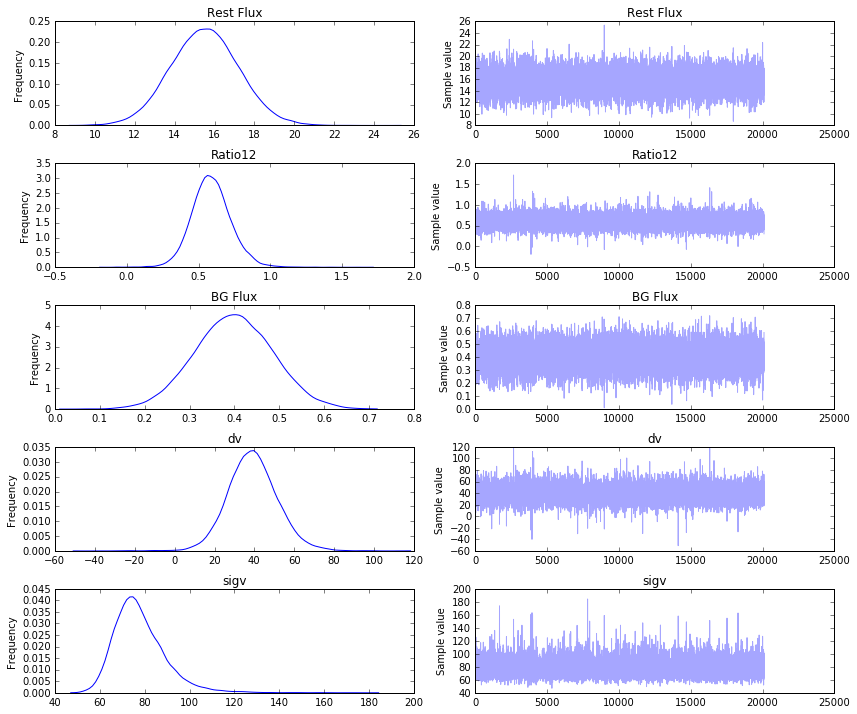

In [194]:
pymc3_chain = build_pymc3_chain(
    dv_truth=50., flux_truth=12., ratio_truth=0.8, sigv_truth=65., bg_truth=0.5, snr=10., seed=123)

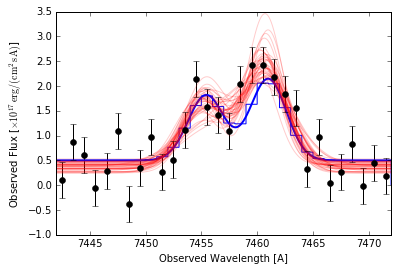

In [195]:
plot_generated(50., 12., 0.8, 65., 0.5, 10., 123, pymc3_chain[::500])

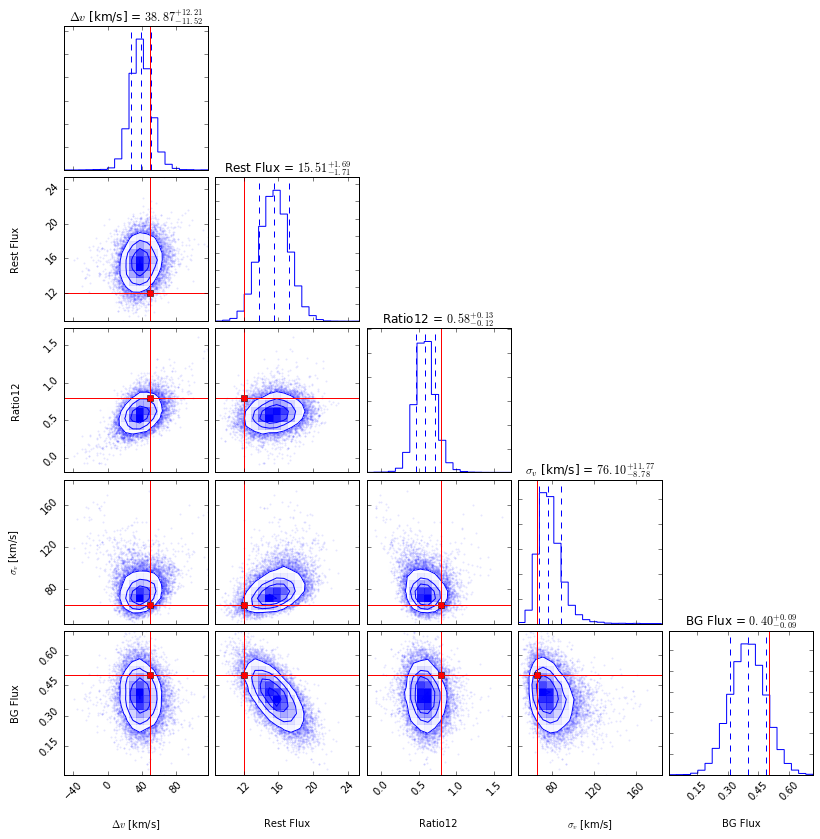

In [196]:
trace = pymc3_chain.reshape(-1,5)
corner.corner(trace,
                        labels=["$\Delta v$ [km/s]", "Rest Flux", "Ratio12", "$\sigma_v$ [km/s]", "BG Flux"],
                        truths=[50, 12, 0.8, 65, 0.5],
                        quantiles=(0.16, 0.5, 0.84),
                        truth_color='r', color='b', show_titles=True);

Applied interval-transform to dv and added transformed dv_interval to model.
Applied interval-transform to sigv and added transformed sigv_interval to model.

== Finding the MAP...

== MAP search took 9.7 seconds.

== Sampling the posterior...
 [-----------------100%-----------------] 20100 of 20100 complete in 58.2 sec
== Sampling took 58.2 seconds.


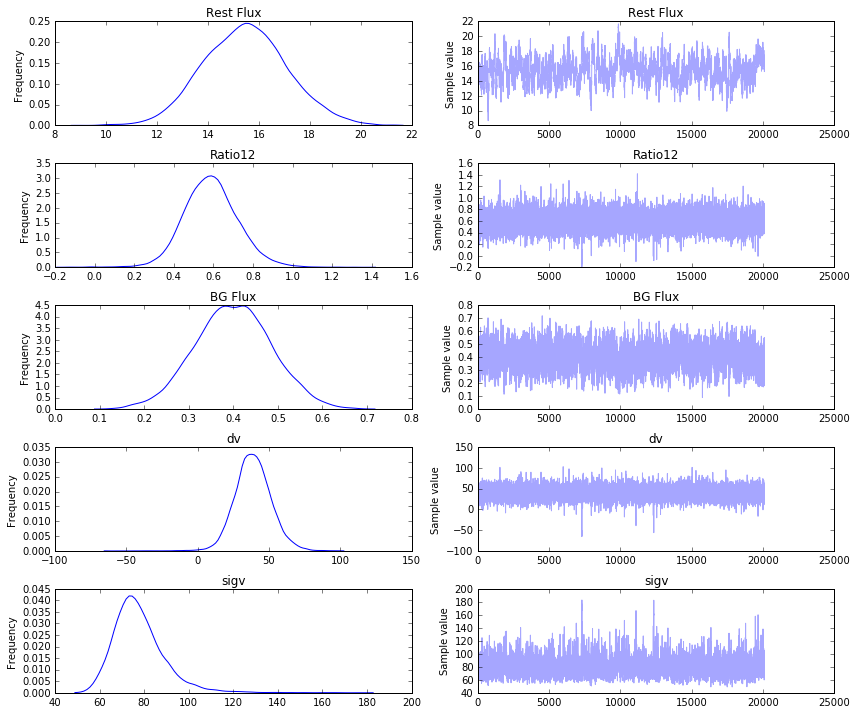

In [199]:
pymc3_chain2 = build_pymc3_chain(
    dv_truth=50., flux_truth=12., ratio_truth=0.8, sigv_truth=65., bg_truth=0.5, snr=10., seed=123, step_type='HMC')

Did we just get unlikely with a particular data realization?  Try a different random seed.

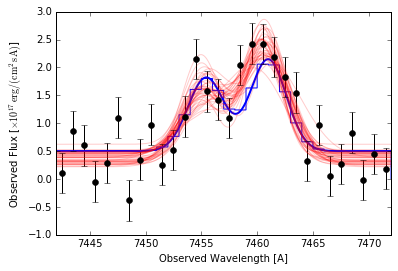

In [202]:
plot_generated(50., 12., 0.8, 65., 0.5, 10., 123, pymc3_chain2[::500])

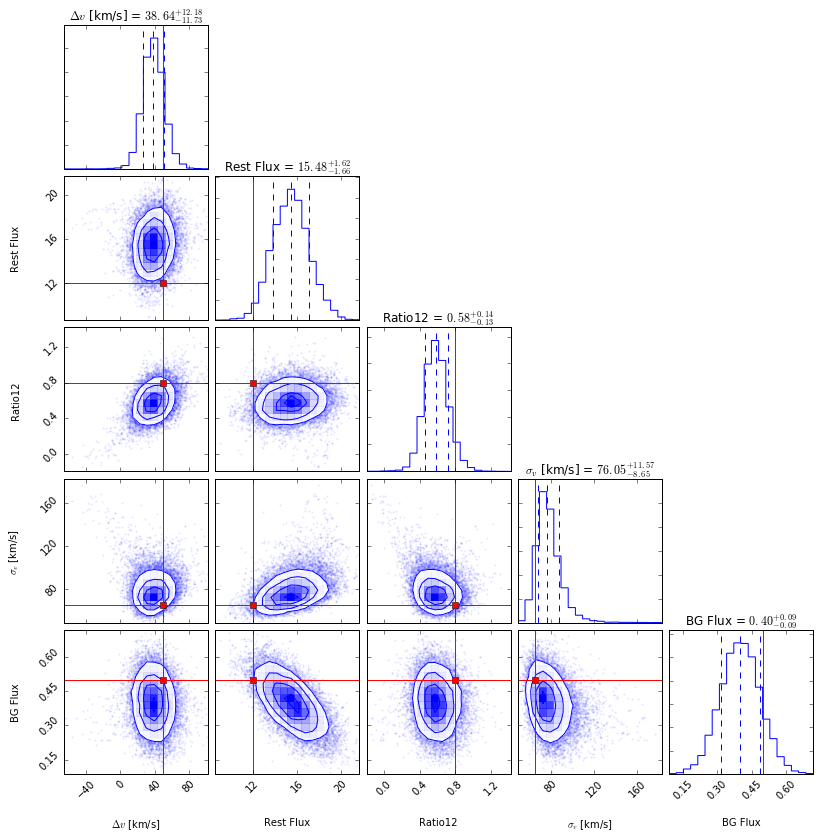

In [201]:
trace2 = pymc3_chain2.reshape(-1,5)
corner.corner(trace2,
                        labels=["$\Delta v$ [km/s]", "Rest Flux", "Ratio12", "$\sigma_v$ [km/s]", "BG Flux"],
                        truths=[50, 12, 0.8, 65, 0.5],
                        quantiles=(0.16, 0.5, 0.84),
                        truth_color='r', color='b', show_titles=True);

Applied interval-transform to dv and added transformed dv_interval to model.
Applied interval-transform to sigv and added transformed sigv_interval to model.

== Finding the MAP...

== MAP search took 7.4 seconds.

== Sampling the posterior...
 [-----------------100%-----------------] 20100 of 20100 complete in 12.0 sec
== Sampling took 12.0 seconds.


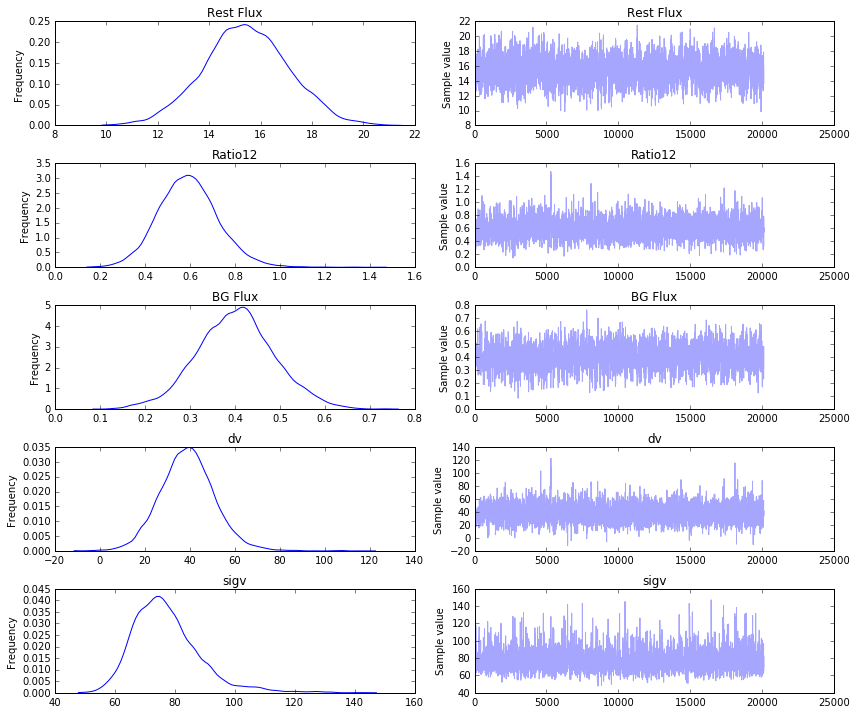

In [205]:
pymc3_chain3 = build_pymc3_chain(
    dv_truth=50., flux_truth=12., ratio_truth=0.8, sigv_truth=65., bg_truth=0.5, snr=10., seed=123, step_type='Metropolis')

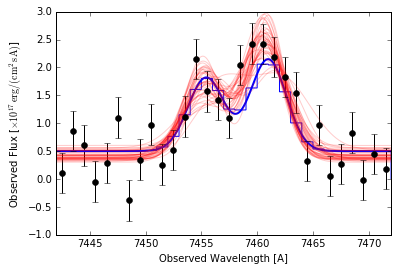

In [206]:
plot_generated(50., 12., 0.8, 65., 0.5, 10., 123, pymc3_chain3[::500])

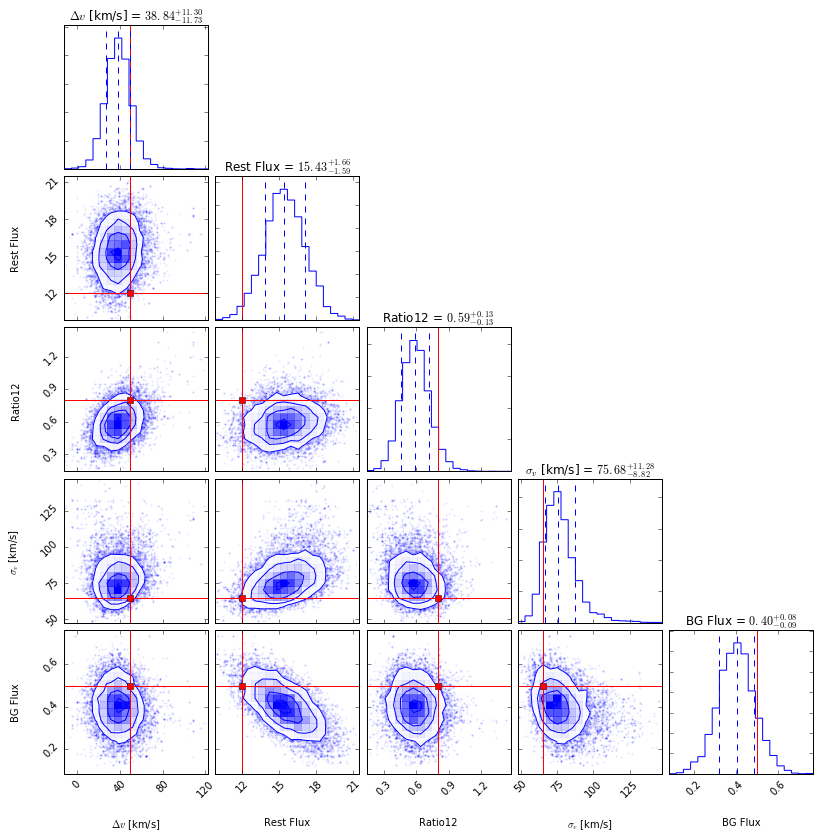

In [207]:
trace3 = pymc3_chain3.reshape(-1,5)
corner.corner(trace3,
                        labels=["$\Delta v$ [km/s]", "Rest Flux", "Ratio12", "$\sigma_v$ [km/s]", "BG Flux"],
                        truths=[50, 12, 0.8, 65, 0.5],
                        quantiles=(0.16, 0.5, 0.84),
                        truth_color='r', color='b', show_titles=True);

Animation on how different samplers do their job: http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/